In [97]:
""" Moving Averages Signals """
import pandas as pd 
import numpy as np 
import sqlite3 as sql 

import sys
sys.path.append('/Users/jerald/Documents/Dir/Python/Stocks')
from bin.main import Manager

class moving_avg(Manager):
    def __init__(self, connections):
        super().__init__(connections)
        self.windows = np.arange(10, 90, 6)
    
    def rename_col(self, df, name):
        """ Rename the Column of a DataFrame """
        return df.rename(columns={df.columns[0]: name})
        
    def ema(self, df, window):
        """ 
            (Wilder's) Exponential Moving Average. 
                Input a Single Column DataFrame Wtih a datetime index
                Returns -> A Single Column DataFrame
        """
        out = df.ewm(alpha=1/window).mean()
        return self.rename_col(out, f'EMA{window}')
    
    def sma(self, df, window):
        """ Simple Moving Average. 
            Input a Single Column DataFrame Wtih a datetime index
            Returns -> A Single Column DataFrame
        """
        out = df.rolling(window=window).mean()
        return self.rename_col(out, f'SMA{window}')
    
    
    def wma(self, df, window): 
        """ Weighted Moving Average. 
            Input a Single Column DataFrame Wtih a datetime index
            Returns -> A Single Column DataFrame
        """
        weights = np.arange(1, window+1)
        # return df.rolling(window=window).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
        out = df.rolling(window=window).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
        return self.rename_col(out, f'WMA{window}')
    
    def ribbon(self, stock, agg = 'h', ma = 'sma'):
        # close = self.Pricedb.get_intraday_close([stock], agg)
        close = self.Pricedb.get_close([stock])
        ma = getattr(self, ma)
        out = pd.concat([close]+[ma(close, window) for window in self.windows], axis=1)
        return out
    
    

In [98]:
pre = '../'
connections = {
    ##### Price Report ###########################
    'daily_db': f'{pre}data/prices/stocks.db', 
    'intraday_db': f'{pre}data/prices/stocks_intraday.db',
    'ticker_path': f'{pre}data/stocks/tickers.json',
    ##### Price Report ###########################
    'inactive_db': f'{pre}data/options/log/inactive.db',
    'backup_db': f'{pre}data/options/log/backup.db',
    'tracking_values_db': f'{pre}data/options/tracking_values.db',
    'tracking_db': f'{pre}data/options/tracking.db',
    'stats_db': f'{pre}data/options/stats.db',
    'vol_db': f'{pre}data/options/vol.db',
    'change_db': f'{pre}data/options/option_change.db', 
    'option_db': f'{pre}data/options/options.db', 
    'options_stat': f'{pre}data/options/options_stat.db',
    'stock_names' : f'{pre}data/stocks/stocks.db'
}
 
m = moving_avg(connections)

Options db Connected: 2024-06-16 16:11:40.073124
Prices Connected: 2024-06-16 16:11:40.073591


In [99]:
import matplotlib.pyplot as plt

<Axes: xlabel='date'>

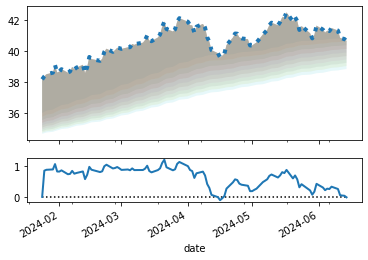

In [101]:
d = m.ribbon('xlf', '28T', 'ema')
pdf = d.tail(100)
fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
ax = ax.flatten()
pdf.xlf.plot(ax=ax[0], linewidth=4, linestyle = 'dotted')

# fill between the moving averages
for col in pdf.columns[5:]:
    ax[0].fill_between(pdf.index, pdf.xlf, pdf[col], alpha=0.1)    
    
ax[1].hlines(0, pdf.index[0], pdf.index[-1], color = 'black', linestyle = 'dotted')
pdf.iloc[:, 1:].diff(axis = 0).sum(axis = 1).plot(ax=ax[1], linewidth=2, linestyle = '-')

In [102]:
# We want stocks that the Fastest Moving Average is Increasing and crossing the majority of the slower moving averages 
# We want stocks with the distance between the moving averages to be decreasing, and almost compressing such that the faster moving average can cross with ease. 
pdf

,xlf,EMA10,EMA16,EMA22,EMA28,EMA34,EMA40,EMA46,EMA52,EMA58,EMA64,EMA70,EMA76,EMA82,EMA88
date,,,,,,,,,,,,,,,
2024-01-24,38.176266,37.487683,37.089201,36.681789,36.323541,36.021010,35.766435,35.550701,35.366200,35.207058,35.068799,34.947988,34.841925,34.748430,34.665693
2024-01-25,38.365551,37.575469,37.168973,36.758324,36.396470,36.089967,35.831413,35.611893,35.423880,35.261514,35.120311,34.996810,34.888288,34.792541,34.707737
2024-01-26,38.505028,37.668425,37.252476,36.837719,36.471776,36.160999,35.898254,35.674787,35.483133,35.317437,35.173197,35.046927,34.935877,34.837815,34.750888
2024-01-29,38.604652,37.762048,37.336987,36.918034,36.547950,36.232871,35.965914,35.738480,35.543162,35.374113,35.226813,35.097752,34.984150,34.883752,34.794681
2024-01-30,39.092815,37.895125,37.446726,37.016888,36.638838,36.316987,36.044086,35.811400,35.611425,35.438229,35.287220,35.154824,35.038212,34.935082,34.843523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-10,41.320000,41.392211,41.324091,41.197539,41.023035,40.812356,40.578983,40.334394,40.087049,39.842714,39.605109,39.376501,39.158157,38.950662,38.754142
2024-06-11,40.849998,41.337990,41.294461,41.181742,41.016855,40.813463,40.585759,40.345603,40.101721,39.860081,39.624560,39.397551,39.180418,38.973825,38.777959
2024-06-12,40.810001,41.285191,41.264182,41.164844,41.009468,40.813361,40.591365,40.355699,40.115342,39.876459,39.643083,39.417729,39.201860,38.996217,38.801050
